# 1. Imports e definições 

In [4]:
import re
import utils as u
import pandas as pd
from unidecode import unidecode
import matplotlib.pyplot as plt

In [5]:
base_path = '../dados/raw'

In [6]:
df_gld = pd.read_csv(f'{base_path}/GLD.csv')
df_petr = pd.read_csv(f'{base_path}/PETR3.csv')
df_sp_500 = pd.read_csv(f'{base_path}/S&P 500.csv')
df_usd_brl = pd.read_csv(f'{base_path}/USD_BRL.csv')
df_vale = pd.read_csv(f'{base_path}/VALE3.csv')

In [37]:
df_gld.head(1)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,07.10.2024,"244,17","244,58","244,82","243,81","3,85M","-0,34%"


In [38]:
df_petr.head(1)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,29.11.2024,"42,62","41,75","42,98","41,75","16,84M","2,08%"


In [39]:
df_sp_500.head(1)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,02.12.2024,"6.047,15","6.040,11","6.053,58","6.035,33","0,00K","0,24%"


In [40]:
df_usd_brl.head(1)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,08.03.2024,"4,9806","4,9337","4,9913","4,9337",NaN,"0,92%"


In [41]:
df_vale.head(1)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,29.11.2024,"58,78","58,25","59,21","58,15","31,02M","2,17%"


# 2. Processamento dos dados

Pré processamento dos dataframes, correção do formato de dados e remoção de notações desenecessárias

In [7]:
df_gld = u.corrige_dataframe(df_gld)
df_petr = u.corrige_dataframe(df_petr)
df_sp_500 = u.corrige_dataframe(df_sp_500)
df_usd_brl = u.corrige_dataframe(df_usd_brl)
df_vale = u.corrige_dataframe(df_vale)

Filtro por data para a equalização dos dados, devido a falta de dados em alguns períodos em alguns dos indicadores

In [11]:
# Garantindo que todos os dataframes têm o mesmo range de datas
start_date = max(df_vale['data'].min(), df_gld['data'].min(), df_petr['data'].min(), df_sp_500['data'].min(), df_usd_brl['data'].min())
end_date = min(df_vale['data'].max(), df_gld['data'].max(), df_petr['data'].max(),  df_sp_500['data'].max(), df_usd_brl['data'].max())

df_vale = df_vale[(df_vale['data'] >= start_date) & (df_vale['data'] <= end_date)]
df_gld = df_gld[(df_gld['data'] >= start_date) & (df_gld['data'] <= end_date)]
df_petr = df_petr[(df_petr['data'] >= start_date) & (df_petr['data'] <= end_date)]
df_sp_500 = df_sp_500[(df_sp_500['data'] >= start_date) & (df_sp_500['data'] <= end_date)]
df_usd_brl = df_usd_brl[(df_usd_brl['data'] >= start_date) & (df_usd_brl['data'] <= end_date)]

Dados com colunas e linhas padronizadas

In [14]:
print(df_vale.shape)
print(df_gld.shape)
print(df_petr.shape)
print(df_sp_500.shape)
print(df_usd_brl.shape)

(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)


Agregação por mês dos indicadores

In [8]:
df_gld_mes = u.agrega_mes(df_gld)
df_petr_mes = u.agrega_mes(df_petr)
df_sp_500_mes = u.agrega_mes(df_sp_500)
df_usd_brl_mes = u.agrega_mes(df_usd_brl)
df_vale_mes = u.agrega_mes(df_vale)

Agregação por ano dos indicadores

In [9]:
df_gld_ano = u.agrega_ano(df_gld)
df_petr_ano = u.agrega_ano(df_petr)
df_sp_500_ano = u.agrega_ano(df_sp_500)
df_usd_brl_ano = u.agrega_ano(df_usd_brl)
df_vale_ano = u.agrega_ano(df_vale)

In [60]:
# Unir os dataframes pela coluna data
df = pd.merge(df_vale[['data', 'fechamento']], df_gld[['data', 'fechamento']], on='data', suffixes=('_vale', '_gld'))
df = pd.merge(df, df_petr[['data', 'fechamento']], on='data')
df.rename(columns={'fechamento': 'fechamento_petr'}, inplace=True)

# Ordenar o dataframe pela data
df.sort_values('data', inplace=True)

# Verificar as primeiras linhas
print(df.head())


# Supondo uma semana específica para previsão (a última semana disponível no dataset)
df_test = df[-7:]
df_train = df[:-7]

# Separar features e target
X_train = df_train[['fechamento_gld', 'fechamento_petr']]
y_train = df_train['fechamento_vale']
X_test = df_test[['fechamento_gld', 'fechamento_petr']]
y_test = df_test['fechamento_vale']


from sklearn.linear_model import LinearRegression

# Criar o objeto de regressão linear
model = LinearRegression()

# Treinar o modelo
model.fit(X_train, y_train)

# Realizar previsões
y_pred = model.predict(X_test)

        data  fechamento_vale  fechamento_gld  fechamento_petr
0 2005-01-03             8.77           43.02            10.48
1 2005-01-04             8.41           42.74            10.45
2 2005-01-05             8.35           42.67            10.39
3 2005-01-06             8.32           42.15            10.49
4 2005-01-07             8.54           41.84            10.53


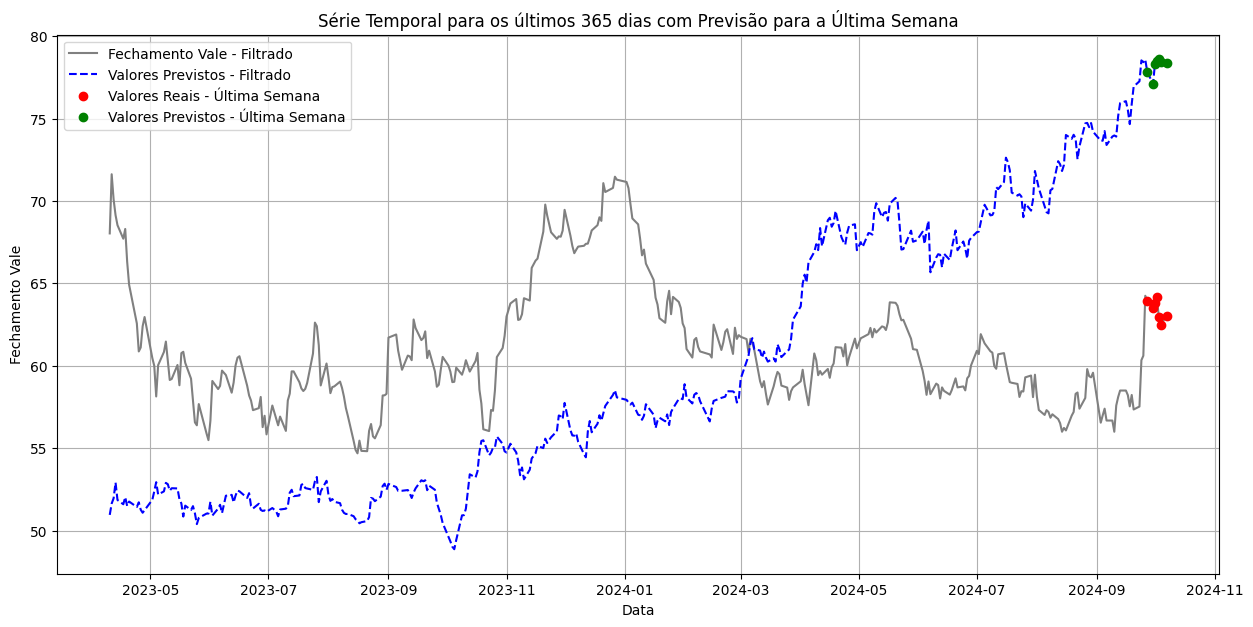

In [61]:
import matplotlib.pyplot as plt

def plot_filtered_time_series(df, model, days_to_show=120):
    # Assegure-se que 'days_to_show' não seja maior que o número de dias disponíveis em 'df'
    days_to_show = min(days_to_show, len(df))
    
    # Dados filtrados para os plots
    df_filtered = df[-days_to_show:]

    # Dados completos para previsões
    X_full = df[['fechamento_gld', 'fechamento_petr']]
    y_full_pred = model.predict(X_full)
    
    # Filtrar as previsões e datas para o intervalo selecionado
    dates_filtered = df_filtered['data']
    y_filtered_pred = y_full_pred[-days_to_show:]

    # Test data from the last week
    dates_test = df_test['data']
    
    # Vamos também filtrar y_real para o intervalo selecionado
    y_filtered_real = df_filtered['fechamento_vale']
    
    # Criar gráfico
    plt.figure(figsize=(15, 7))
    plt.plot(dates_filtered, y_filtered_real, label='Fechamento Vale - Filtrado', color='gray')
    plt.plot(dates_filtered, y_filtered_pred, '--', label='Valores Previstos - Filtrado', color='blue')
    plt.scatter(dates_test, y_test, color='red', label='Valores Reais - Última Semana', zorder=5)
    plt.scatter(dates_test, y_pred, color='green', label='Valores Previstos - Última Semana', zorder=5)
    plt.title(f'Série Temporal para os últimos {days_to_show} dias com Previsão para a Última Semana')
    plt.xlabel('Data')
    plt.ylabel('Fechamento Vale')
    plt.legend()
    plt.grid(True)
    plt.show()

# Chame a função com o número de dias que deseja visualizar
plot_filtered_time_series(df, model, days_to_show=365)  # Exemplo para mostrar o último ano

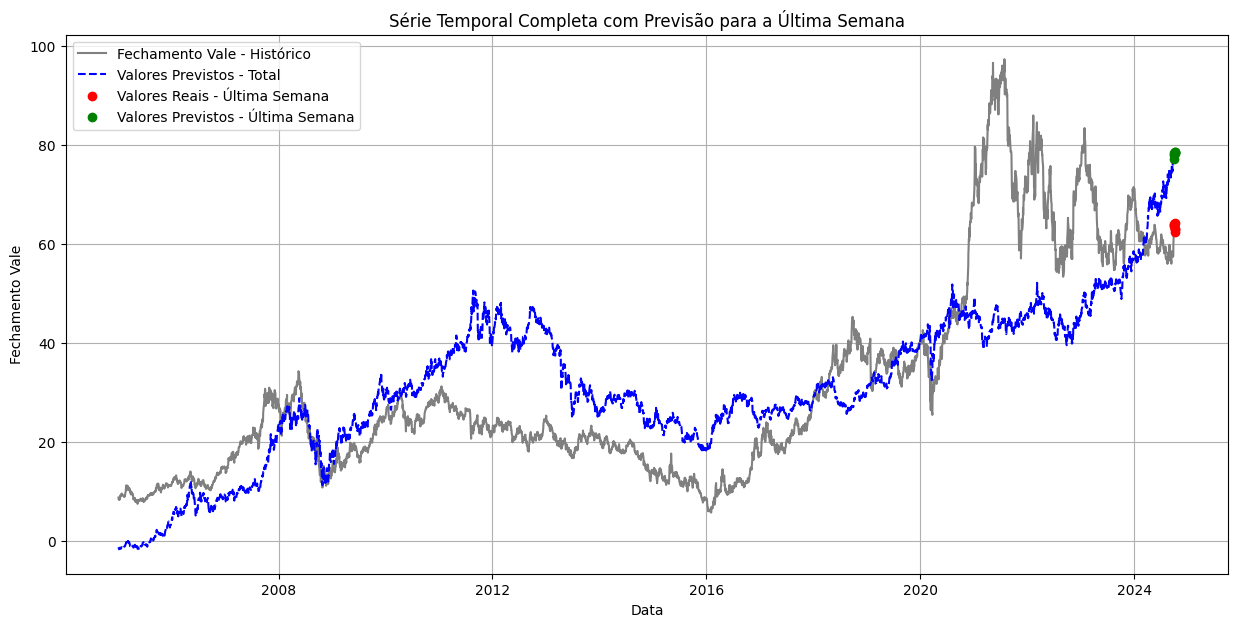

In [62]:
import matplotlib.pyplot as plt

# Dados completos para o eixo x e para a série temporal de fechamento da Vale
dates_full = df['data']
vale_closing_full = df['fechamento_vale']

# Datas para os valores de teste e previsão
dates_test = df_test['data']

# Prever tudo de novo com o modelo ajustado para ter os preditos no contexto completo
X_full = df[['fechamento_gld', 'fechamento_petr']]
y_full_pred = model.predict(X_full)

# Criar gráfico
plt.figure(figsize=(15, 7))
plt.plot(dates_full, vale_closing_full, label='Fechamento Vale - Histórico', color='gray')
plt.plot(dates_full, y_full_pred, '--', label='Valores Previstos - Total', color='blue')
plt.scatter(dates_test, y_test, color='red', label='Valores Reais - Última Semana', zorder=5)
plt.scatter(dates_test, y_pred, color='green', label='Valores Previstos - Última Semana', zorder=5)
plt.title('Série Temporal Completa com Previsão para a Última Semana')
plt.xlabel('Data')
plt.ylabel('Fechamento Vale')
plt.legend()
plt.grid(True)
plt.show()